In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

In [354]:
import spotipy.util as util
import spotipy
import requests
import matplotlib.pyplot as plt
import socket
import array
import time
from bisect import bisect_left

In [4]:
user_id = ''
client_id=''
client_secret=''
scope = 'user-read-currently-playing,user-read-playback-state'

In [368]:
token = util.prompt_for_user_token(user_id, scope,
                                   client_id=client_id,
                                   client_secret=client_secret,
                                   redirect_uri='http://localhost:8000/')

In [369]:
sp = spotipy.Spotify(auth=token)

In [310]:
current_playing = sp._get('me/player/currently-playing')

In [352]:
current_playing['item']['artists'][0]['name'], current_playing['item']['name']

('The Knife', 'Listen Now')

In [311]:
analysis = sp._get('audio-analysis/' + current_playing['item']['id'])

In [348]:
analysis['bars'][:2]

[{'start': 0.06111, 'duration': 1.46978, 'confidence': 0.489},
 {'start': 1.53089, 'duration': 1.46458, 'confidence': 0.546}]

In [347]:
analysis['beats'][:2]

[{'start': 0.06111, 'duration': 0.36898, 'confidence': 1.0},
 {'start': 0.43009, 'duration': 0.36792, 'confidence': 0.826}]

In [346]:
analysis['segments'][:1]

[{'start': 0.0,
  'duration': 0.41791,
  'confidence': 1.0,
  'loudness_start': -60.0,
  'loudness_max_time': 0.07244,
  'loudness_max': -5.366,
  'pitches': [0.417,
   0.551,
   0.538,
   1.0,
   0.772,
   0.747,
   0.536,
   0.593,
   0.32,
   0.762,
   0.577,
   0.438],
  'timbre': [32.278,
   151.866,
   80.945,
   -367.861,
   81.092,
   256.167,
   69.902,
   22.089,
   -31.833,
   49.119,
   -56.521,
   11.736]},
 {'start': 0.41791,
  'duration': 0.09297,
  'confidence': 0.04,
  'loudness_start': -13.175,
  'loudness_max_time': 0.01334,
  'loudness_max': -7.223,
  'pitches': [0.239,
   0.755,
   1.0,
   0.854,
   0.454,
   0.25,
   0.155,
   0.166,
   0.179,
   0.252,
   0.187,
   0.152],
  'timbre': [49.846,
   151.654,
   -52.308,
   -27.851,
   11.71,
   -62.051,
   -25.347,
   20.099,
   -18.222,
   -24.284,
   9.733,
   10.143]}]

In [345]:
analysis['sections'][:2]

[{'start': 0.0,
  'duration': 23.8499,
  'confidence': 1.0,
  'loudness': -8.02,
  'tempo': 163.99,
  'tempo_confidence': 0.639,
  'key': 8,
  'key_confidence': 0.0,
  'mode': 1,
  'mode_confidence': 0.0,
  'time_signature': 4,
  'time_signature_confidence': 1.0},
 {'start': 23.8499,
  'duration': 24.51498,
  'confidence': 0.637,
  'loudness': -7.619,
  'tempo': 164.035,
  'tempo_confidence': 0.511,
  'key': 8,
  'key_confidence': 0.349,
  'mode': 1,
  'mode_confidence': 0.403,
  'time_signature': 4,
  'time_signature_confidence': 1.0}]

In [344]:
analysis['tatums'][:2]

[{'start': 0.06111, 'duration': 0.18449, 'confidence': 1.0},
 {'start': 0.2456, 'duration': 0.18449, 'confidence': 1.0}]

## gantt of blocks

In [42]:
names = ('bars', 'beats', 'sections', 'segments', 'tatums')

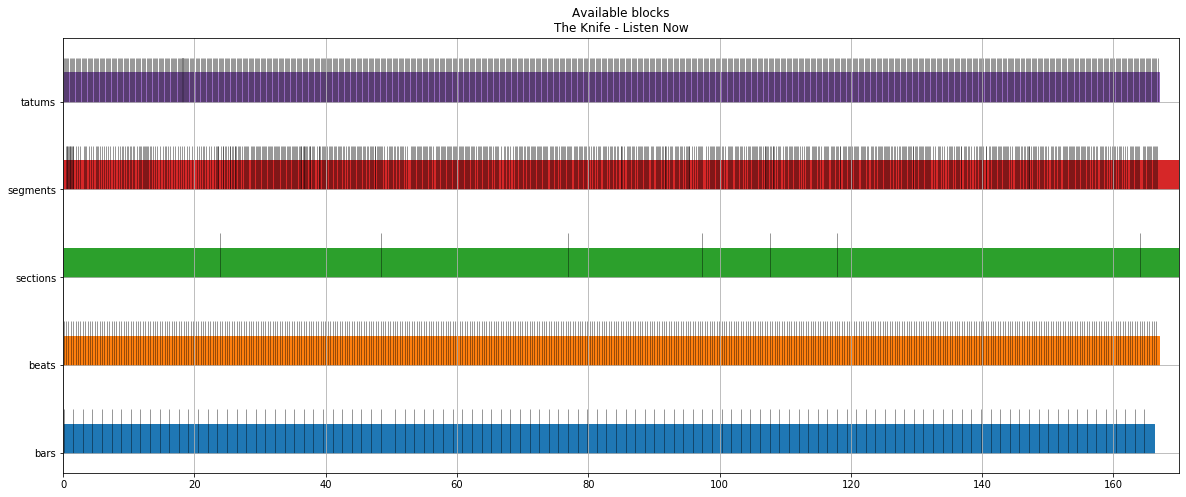

In [365]:
fig, ax = plt.subplots(figsize=(20, 8)) 
ax.set_xlim(0, current_playing['item']['duration_ms'] / 1000)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.title('Available blocks\n' + current_playing['item']['artists'][0]['name'] + ' - ' + current_playing['item']['name'])
ax.grid(True)
for n, name in enumerate(names):
    ax.broken_barh(
        [(x['start'], x['duration']) for x in analysis[name]],
        (3 * n, 1), color=colors[n])
    ax.broken_barh(
        [(x['start'], 0.0001) for x in analysis[name]],
        (3 * n, 1.5), color='black', alpha=0.4)

ax.set_yticks(range(0, 3 * len(names), 3))
ax.set_yticklabels(names)
pass

# leds check

In [77]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
sock.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)

In [85]:
def send(pixels):
    colors = [color for pixel in pixels for color in pixel]
    line = array.array('B', colors).tostring()
    sock.sendto(line, ('192.168.2.255', 42424))

In [142]:
send([(50, 100, 150)] * 60)

/Users/nvbn/.virtualenvs/spotify-gerland/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """Entry point for launching an IPython kernel.


## Colors

In [318]:
SCALE = (255, 255, 255)

from typing import List, Tuple, Callable

# Shared communication
RawSpotifyResponse = Dict[str, Any]
Colors = List[Tuple[int, int, int]]


def _normalize(pv: float) -> float:
    if pv < 0:
        return 0.
    elif pv > 255:
        return 255.
    else:
        return pv


_scale_pixel = lambda p: (int(_normalize(p[0]) * SCALE[0] / 255),
                          int(_normalize(p[1]) * SCALE[1] / 255),
                          int(_normalize(p[2]) * SCALE[2] / 255))


In [341]:
def make_get_current_colors(analysis: RawSpotifyResponse, leds: int) -> Callable[[float], Colors]:
    def make_get_current(name):
        keys = [x['start'] for x in analysis[name]]
        key_to_x = {x['start']: x for x in analysis[name]}
        return lambda t: key_to_x[keys[bisect_left(keys, t) - 1]]

    get_current_segmnet = make_get_current('segments')
    get_current_section = make_get_current('sections')
    get_current_beat = make_get_current('beats')

    def make_scale(name):
        xs = [x[name] for x in analysis['sections']]
        min_xs = min(xs)
        max_xs = max(xs)
        return lambda x: (x - min_xs) / (max_xs - min_xs)

    scale_loudness = make_scale('loudness')
    scale_tempo = make_scale('tempo')

    def get_current_colors(t):
        segment = get_current_segmnet(t)
        section = get_current_section(t)
        beat = get_current_beat(t)

        beat_color = BASE_COLOR_MULTIPLIER * (t - beat['start'] + beat['duration']) / beat['duration']
        tempo_color = BASE_COLOR_MULTIPLIER * scale_tempo(section['tempo'])
        pitch_colors = [BASE_COLOR_MULTIPLIER * p for p in segment['pitches']]

        loudness_multiplier = 1 + LOUDNESS_MULTIPLIER * scale_loudness(section['loudness'])

        colors = ((beat_color * loudness_multiplier,
                   tempo_color * loudness_multiplier,
                   pitch_colors[n // (leds // 12)] * loudness_multiplier)
                  for n in range(leds))

        if section['mode'] == 0:
            order = (0, 1, 2)
        elif section['mode'] == 1:
            order = (1, 2, 0)
        else:
            order = (2, 0, 1)

        ordered_colors = ((color[order[0]], color[order[1]], color[order[2]])
                          for color in colors)

        return [_scale_pixel(color) for color in ordered_colors]

    return get_current_colors


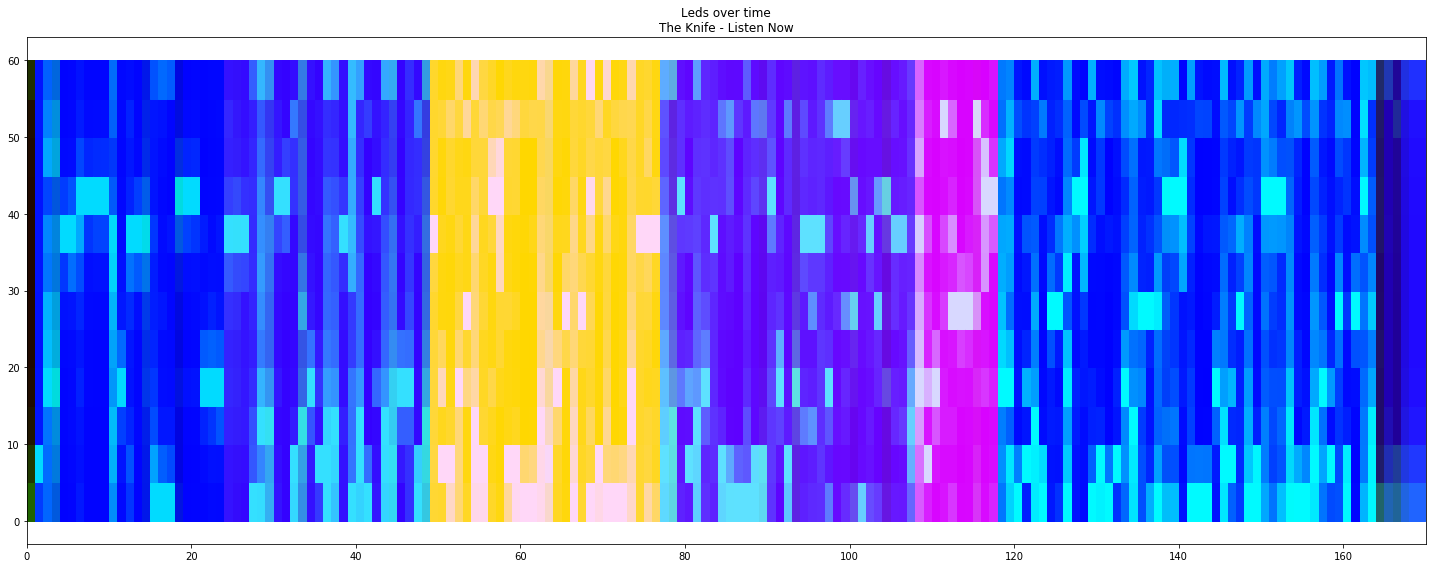

In [364]:
fig, ax = plt.subplots(figsize=(20, 8)) 
ax.set_xlim(0, current_playing['item']['duration_ms'] / 1000)
get_current_colors = make_get_current_colors(analysis, 60)
plt.title('Leds over time\n' + current_playing['item']['artists'][0]['name'] + ' - ' + current_playing['item']['name'])
for t in range(0, int(current_playing['item']['duration_ms'] / 1000)):
    for n, led in enumerate(get_current_colors(t)):
        plt.broken_barh([(t, 1)], (n, 1), color=(led[0] / 255, led[1] / 255, led[2] / 255))

    
plt.tight_layout()

In [366]:
def test():
    current_playing = sp._get('me/player/currently-playing')
    analysis = sp._get('audio-analysis/' + current_playing['item']['id'])
    fig, ax = plt.subplots(figsize=(20, 8)) 
    ax.set_xlim(0, current_playing['item']['duration_ms'] / 1000)
    get_current_colors = make_get_current_colors(analysis, 60)
    plt.title('Leds over time\n' + current_playing['item']['artists'][0]['name'] + ' - ' + current_playing['item']['name'])
    for t in range(0, int(current_playing['item']['duration_ms'] / 1000)):
        for n, led in enumerate(get_current_colors(t)):
            plt.broken_barh([(t, 1)], (n, 1), color=(led[0] / 255, led[1] / 255, led[2] / 255))


    plt.tight_layout()

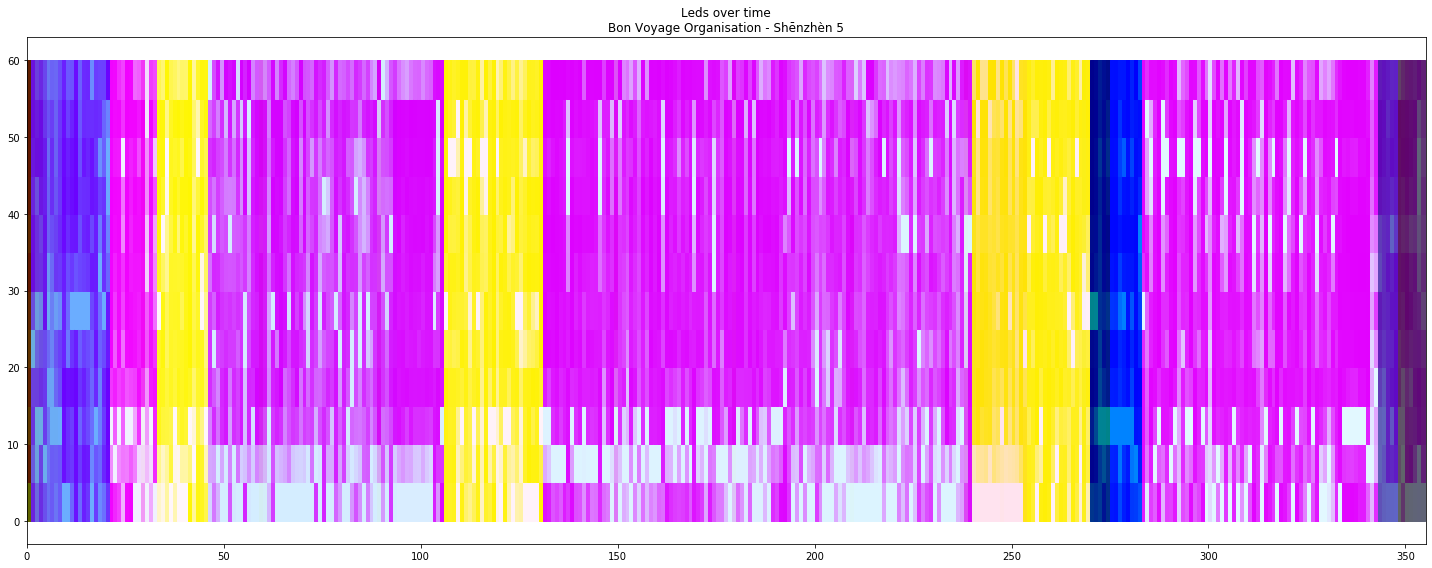

In [370]:
test()

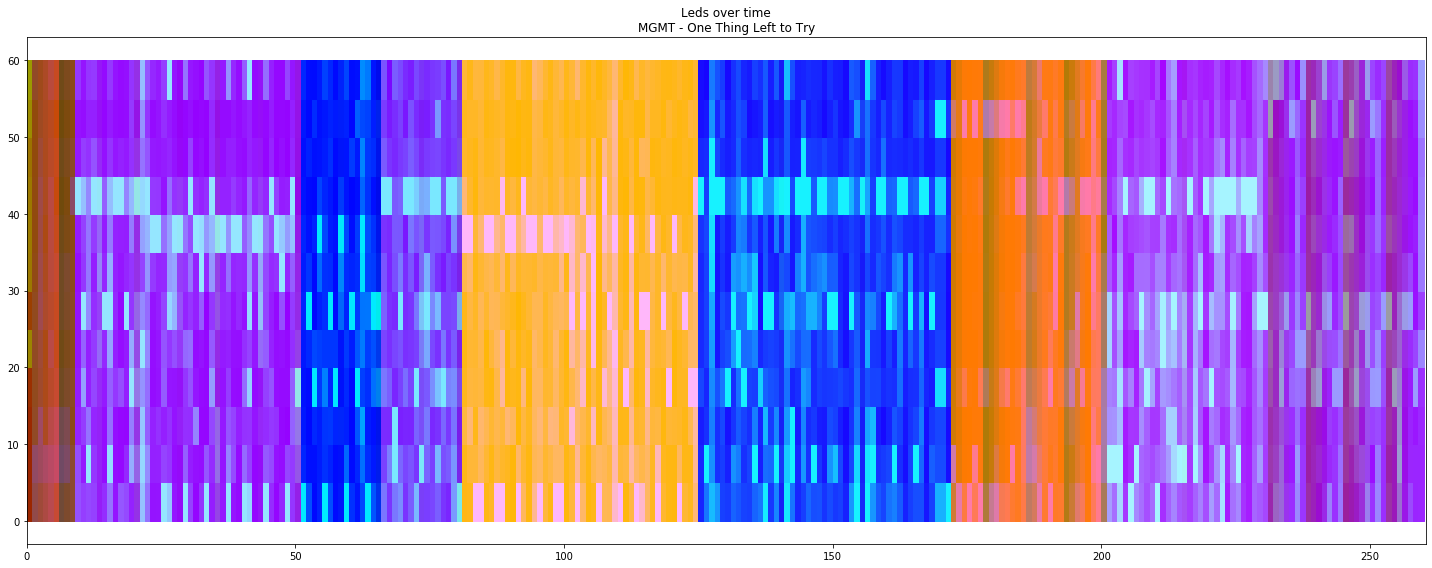

In [371]:
test()

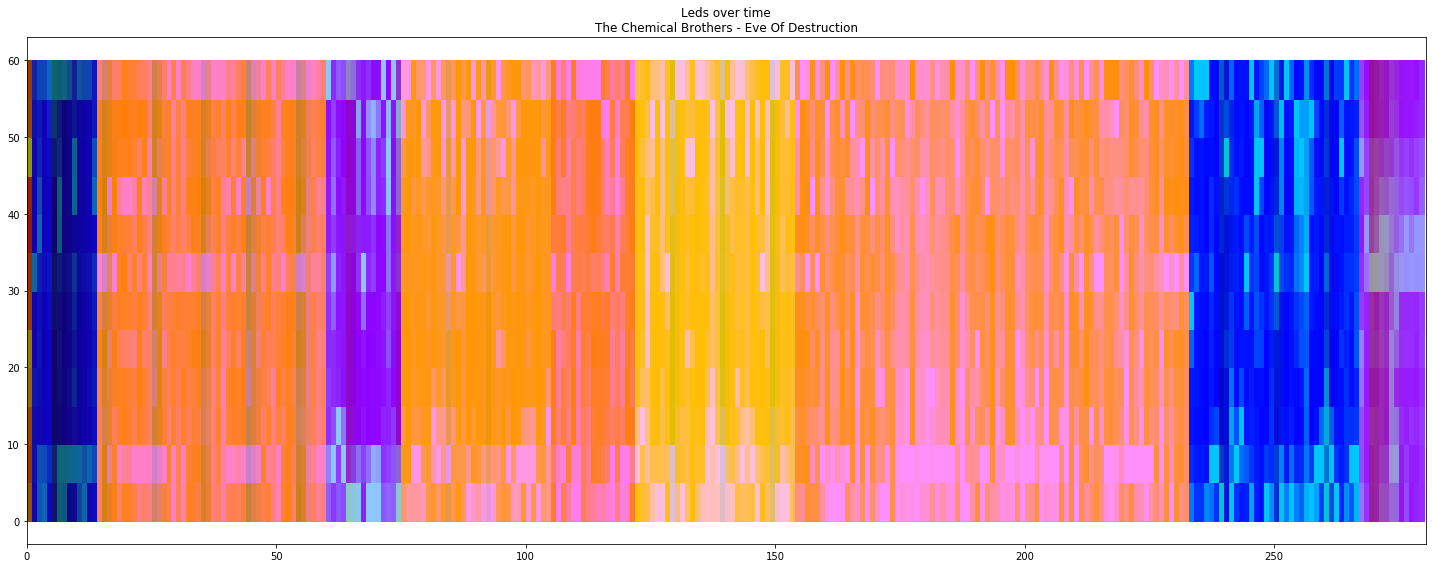

In [372]:
test()

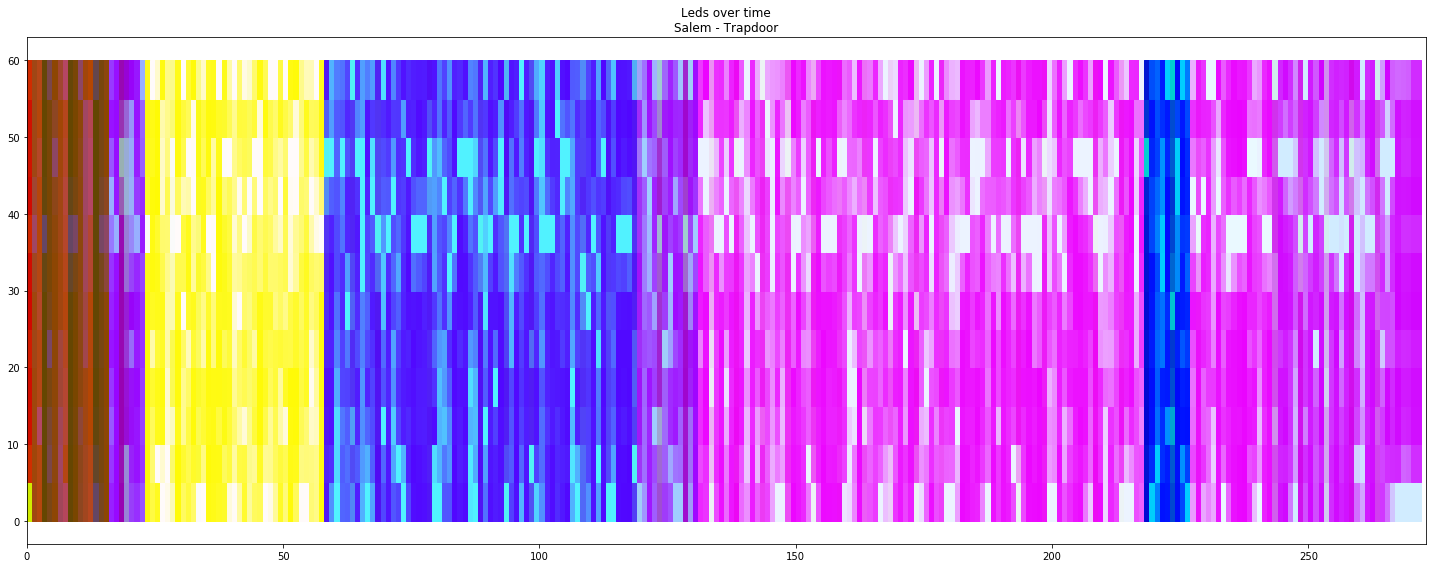

In [373]:
test()

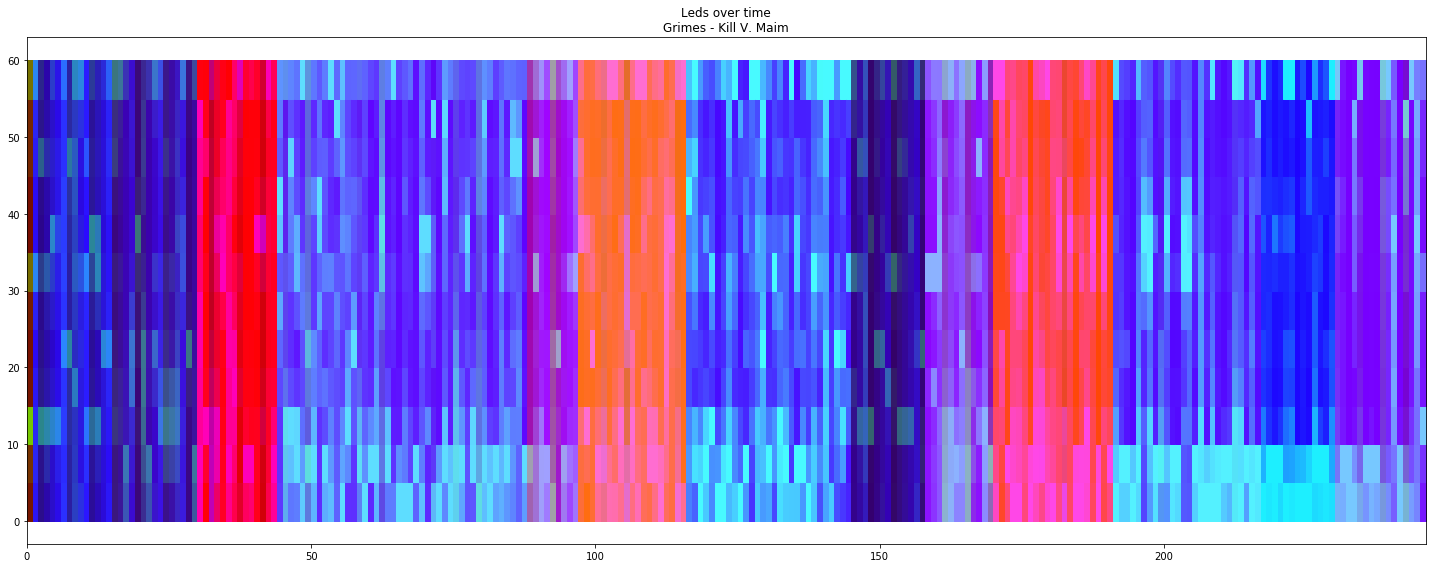

In [374]:
test()